- This code has written by Ahmadreza Attarpour (a.attarpour@mail.utoronto.ca)
- It's a practice to check how we can use LangChain/LangGraph to build tools and agents

-------------------------------------

# building a complex agent system with RAG

🔧 1. Purpose of the Code

- Takes a user question.

- Classifies whether it should use a RAG approach or a plain LLM response.

- Routes the query accordingly.

- Produces a final answer.

Summary of the code:


| Concept                                          | Purpose                                                       |
| ------------------------------------------------ | ------------------------------------------------------------- |
| `AgentState`                                     | Tracks state across graph steps, specifically `messages`.     |
| `Annotated[Sequence[BaseMessage], operator.add]` | Tells LangGraph to keep adding messages across steps.         |
| `PydanticOutputParser`                           | Forces LLM output to follow a JSON-like schema.               |
| `function_SELECT`                                | Uses LLM + parser to choose a topic.                          |
| `function_ROUTER`                                | Picks the next step (`RAG` or `LLM`) based on selected topic. |
| `function_RAG`                                   | Answer using retrieved documents.                             |
| `function_LLM`                                   | Answer using LLM alone.                                       |
| `LangGraph`                                      | Orchestrates everything using a directed graph.               |


In [1]:
####----------------------Build the LLM and embeddings----------------------####


# load the environment variables from the .env file
from dotenv import load_dotenv
import os
load_dotenv()

# Read the variable from the environment and set it as a env variable
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")
LANGCHAIN_PROJECT = os.getenv("LANGCHAIN_PROJECT")
if GOOGLE_API_KEY:
    os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
if LANGCHAIN_API_KEY:
    os.environ["LANGCHAIN_API_KEY"] = LANGCHAIN_API_KEY
if LANGCHAIN_PROJECT:
    os.environ["LANGCHAIN_PROJECT"] = LANGCHAIN_PROJECT
if os.getenv("GROQ_API_KEY"):
    os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
if os.getenv("SERPER_API_KEY"):
    os.environ["SERPER_API_KEY"] = os.getenv("SERPER_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"


# # load the LLM and embeddings from langchain_google_genai
from langchain_huggingface import HuggingFaceEmbeddings
embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
from langchain_groq import ChatGroq
llm = ChatGroq(model="llama3-70b-8192")

llm.invoke("Hello, how are you?")

/Users/ahmadreza/anaconda3/envs/aa_agent/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AIMessage(content='I\'m just a language model, I don\'t have feelings or emotions like humans do, so I don\'t have good or bad days. I\'m always "on" and ready to help with any questions or tasks you may have! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 55, 'prompt_tokens': 16, 'total_tokens': 71, 'completion_time': 0.177355229, 'prompt_time': 0.000204897, 'queue_time': 0.012061166, 'total_time': 0.177560126}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_bf16903a67', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--d533d771-f91c-4cd0-a5d3-194f08fccfa2-0', usage_metadata={'input_tokens': 16, 'output_tokens': 55, 'total_tokens': 71})

In [3]:
####----------------------Build the RAG----------------------####


from langchain_community.document_loaders import TextLoader, DirectoryLoader 
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain import PromptTemplate
from langchain_core.runnables import RunnableParallel, RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser

# load the documents
loader = DirectoryLoader('./data', glob="./japan*.txt", loader_cls=TextLoader)
docs = loader.load()
print(docs)

text_splitter = RecursiveCharacterTextSplitter(chunk_size=200, chunk_overlap=80)
new_docs = text_splitter.split_documents(documents = docs)
doc_strings = [doc.page_content for doc in new_docs]

db = Chroma.from_documents(new_docs, embeddings)
retriever = db.as_retriever(search_kwargs={"k":3})

query = "what is the GDP of japan?"
docs = retriever.get_relevant_documents(query)
print(docs[0].page_content)
print(docs[0].metadata)

for doc in docs:
    print(doc)

[Document(metadata={'source': 'data/japan.txt'}, page_content='Industrial revival hope for Japan\n\nJapanese industry is growing faster than expected, boosting hopes that the country\'s retreat back into recession is over.\n\nIndustrial output rose 2.1% - adjusted for the time of year - in January from a month earlier. At the same time, retail sales picked up faster than at any time since 1997. The news sent Tokyo shares to an eight-month high, as investors hoped for a recovery from the three quarters of contraction seen from April 2004 on. The Nikkei 225 index ended the day up 0.7% at 11,740.60 points, with the yen strengthening 0.7% against the dollar to 104.53 yen. Weaker exports, normally the engine for Japan\'s economy in the face of weak domestic demand, had helped trigger a 0.1% contraction in the final three months of last year after two previous quarters of shrinking GDP. Only an exceptionally strong performance in the early months of 2004 kept the year as a whole from showing

/Users/ahmadreza/anaconda3/envs/aa_agent/lib/python3.12/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [4]:
####----------------------Build the RAG function----------------------####

def function_RAG(AgentState):

    print(" -> Calling RAG ->")
    messages = AgentState["messages"]
    question = messages[0] # fetching the first user question

    template = """Answer the question based only on the following context:
    {context}
    
    Question: {question}
    """

    prompt = PromptTemplate.from_template(template)

    retrieval_chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser() 
    )
    result = retrieval_chain.invoke(question)

    return {"messages": [result]}

AgentState is a dictionary-like structure (via TypedDict) used to represent the state your agent tracks.

It contains one key: "messages".

🔍 What's Annotated[Sequence[BaseMessage], operator.add]?
You're saying:

- This key is a list of LangChain BaseMessages.

- The special annotation operator.add is used to accumulate or concatenate messages as the graph proceeds.

- Think of AgentState as a memory or log of conversation/messages flowing through your graph.



In [5]:
####----------------------Class state Agent----------------------####


from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):

    """State of the agent, including messages and other relevant data.
    the message field shouldbe be a sequence of strings and we annotate it with
    `operator.add` to allow concatenation of messages."""

    messages: Annotated[Sequence[BaseMessage], operator.add]


We need Pydantic to help validate and structure typed Python data (like JSON or dicts) using classes.

The following class defines the format of your structured output.

Indeed, we're forcing LLM to  return something like:


{

  "Topic": "Japan",

  "Reasoning": "The user asked about Japanese history."
  
}



1. TypedDict:

TypedDict is a special type that allows you to define a dictionary in Python where each key has a specific type. It’s useful when you want to enforce type checks on the keys and values of a dictionary.

2. Annotated:

Annotated is used to add metadata or constraints to a type. It’s typically used for adding additional information, like constraints or descriptions, to the type.

3. Sequence[BaseMessage]:

Sequence is a generic type from Python's typing module that represents a list-like structure (such as a list or tuple) where the order matters, and you can access elements by their position.

4. BaseMessage:

Basemessage: This assumes you're working with the LangChain framework, and BaseMessage is part of its core messaging system. It is typically used when handling or processing messages in LangChain's workflows

5. operator.add:

operator.add is a function from Python’s operator module that performs addition (+) on its arguments. In this context, operator.add is being used as metadata for the Annotated type, likely suggesting that the sequence of BaseMessage objects is meant to be "added" or concatenated with another sequence at some point. It’s an indicator of how the messages field will be treated in the logic of your program.

6. TopicSelectionParser: A Pydantic model that defines two fields (Topic and Reasoning), both of which are required to be strings.

7. Field: Adds metadata, like descriptions, and can also be used for validation and constraints.

8. Pydantic’s Role: Ensures that the data matches the expected structure and types, raising validation errors if the data is invalid.

# Putting It All Together:

The line messages: Annotated[Sequence[BaseMessage], operator.add] defines a field messages that:

Must be a sequence (like a list or tuple) of BaseMessage objects. Has the additional annotation operator.add, which suggests that this sequence is intended to support addition (i.e., concatenation of multiple sequences of messages).

messages: Annotated[Sequence[BaseMessage], operator.add]

"messages": [BaseMessage("Hello!", "Alice"), BaseMessage("Hi!", "Bob")]

In [7]:
####----------------------Pydantic object----------------------####

from pydantic import BaseModel, Field
from langchain.output_parsers import PydanticOutputParser

class TopicSelectionParser(BaseModel):
    Topic: str = Field(description="Selected Topic")
    Reasoning: str = Field(description="Reasoning behind topic selection")

# This tells the LLM how to structure its output.
# It also includes parser.get_format_instructions() 
# which tells the LLM to format its output as JSON-like text, 
# conforming to the TopicSelectionParser model.
parser = PydanticOutputParser(pydantic_object=TopicSelectionParser)

In [8]:
print(parser.get_format_instructions())

# this will be called inside the function_SELECT to ensure the output is in the correct format

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"properties": {"Topic": {"description": "Selected Topic", "title": "Topic", "type": "string"}, "Reasoning": {"description": "Reasoning behind topic selection", "title": "Reasoning", "type": "string"}}, "required": ["Topic", "Reasoning"]}
```


In [9]:
####----------------------Function 1 to whether use RAG or other path----------------------####

def function_SELECT(state):

    messages = state["messages"]
    question = messages[-1]

    template = """
    Your task is to classify the given user query into one of the following categories: [Japan, Note Related]
    Only respond with the category name and nothing else.
    
    user query: {question}
    {format_instructions}
    """

    prompt = PromptTemplate(template=template,
                            input_variables=["question"],
                            partial_variables={"format_instructions": parser.get_format_instructions()}
                            )

    chain = prompt | llm | parser

    response = chain.invoke({"question": question, "format_instructions": parser.get_format_instructions()})

    print(response)

    return {"messages": [response.Topic]}



In [10]:
# let's looks at the output of the function_SELECT
state = {"messages": ["tell me about Japanese industry?"]}
function_SELECT(state)

Topic='Japan' Reasoning="The query mentions 'Japanese' which is a clear indicator of the topic being related to Japan"


{'messages': ['Japan']}

Then {'messages': ['Japan']} will be passed to next function which is router.

In [11]:
####----------------------Router function----------------------####

def function_ROUTER(state):
    print('-> Router ->')
    messages = state["messages"]

    last_message = messages[-1]

    if 'Japan' in last_message:

        return 'RAG Call'
    
    else:

        return 'LLM Call'


In [12]:
####----------------------LLM function----------------------####

def function_LLM(state):

    print('-> LLM Call ->')

    messages = state["messages"]
    question = messages[0]  # fetching the first user question

    # normal LLM call
    complete_query = "Answer the question with your knowledge of the real world. Following is the question: " + question
    response = llm.invoke(complete_query)

    return {"messages": [response.content]}


In [13]:
####----------------------let's build the graph----------------------####

from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentState)

workflow.add_node("agent", function_SELECT)
workflow.add_node("RAG", function_RAG)
workflow.add_node("LLM", function_LLM)
workflow.set_entry_point("agent")

workflow.add_conditional_edges(
    "agent",
    function_ROUTER,
    {
        "RAG Call": "RAG",
        "LLM Call": "LLM"
    }
)

workflow.add_edge("RAG", END)
workflow.add_edge("LLM", END)

app = workflow.compile()

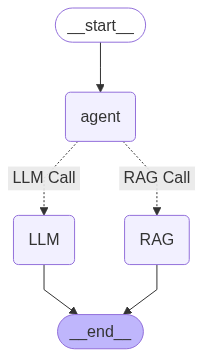

In [14]:
# let's visualize the graph
from IPython.display import display, Image

try: 
    display(Image(app.get_graph().draw_mermaid_png()))

except Exception as e:
    print(e)

In [15]:
input = {"messages": ["What is the capital of France?"]}

output = app.invoke(input)
print(output)

Topic='Note Related' Reasoning='The query is not related to Japan and appears to be a note or a question about a general topic.'
-> Router ->
-> LLM Call ->
{'messages': ['What is the capital of France?', 'Note Related', "That's an easy one! The capital of France is Paris."]}


In [16]:
input = {"messages": ["who invented llama?"]}

output = app.invoke(input)
print(output)

Topic='Note Related' Reasoning="The query does not seem to be related to Japan, and the concept of 'who invented llama' is not a valid or coherent idea, so it is classified as Note Related."
-> Router ->
-> LLM Call ->
{'messages': ['who invented llama?', 'Note Related', 'I think there may be a bit of confusion here!\n\nLlamas are not invented by humans. They are domesticated mammals that originated from South America, specifically the Andean regions of present-day Peru, Bolivia, Ecuador, and Chile.\n\nLlamas are believed to have descended from the wild guanaco (Lama guanicoe) and vicuña (Vicugna vicugna), which are also native to the Andes. The process of domestication is thought to have occurred around 6,500 to 7,000 years ago, during the Neolithic period.\n\nThe indigenous people of the Andes, such as the Quechua and Aymara, are credited with domesticating and breeding llamas for their wool, milk, and meat, as well as for use as pack animals. They were an essential part of the Andea

In [17]:
input = {"messages": ["what's the GDP of Japan?"]}

output = app.invoke(input)
print(output)

Topic='Japan' Reasoning=''
-> Router ->
 -> Calling RAG ->


/Users/ahmadreza/anaconda3/envs/aa_agent/lib/python3.12/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{'messages': ["what's the GDP of Japan?", 'Japan', 'According to the provided context, the GDP of Japan for different years is:\n\n* 2022: $4,256.41B\n* 2021: $5,034.62B\n* 2020: $5,055.59B\n* 2019: $5,117.99B\n\nThere is no single answer for the GDP of Japan, as it varies by year.']}
